# Self Learning

1. see the dft data as unlabeled data, and then we use the xgboost model which trained on exp set to label the dft data.
2. discard items that differ significantly(**Δ>1**) between exp model prediction and dft calculation.
3. use the labeled dft data and exp data together to train model and then label the dft data again.
4. Repeat the above steps.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'/workspaces/Bg_pre2'

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False


In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [5]:
dft_train_X.shape, exp_train_X.shape, mixed_test_X.shape, mixed_test_y.shape

((8275, 64), (2545, 64), (1170, 64), (1170,))

In [6]:
from xgboost import XGBRegressor
from sklearn.base import clone

In [7]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9, reg_lambda=0.5, alpha=0.5,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
exp_model = SingleModel(clone(xgb), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   3.3s
Model training completed!


In [8]:
# 1. total dft train data 
self_learn_model = exp_model
eventually_model = None
# 
LARGE_ERROR = 0.5
SMALL_ERROR_RATE = 0.95
EXP_RATIO = 0.5
# track
iteration_metrics = []  

for i in range(100):
    pred_y = self_learn_model.predict(dft_train_X)

    # discard the samples with large error
    # get the samples with small error  
    small_error_index = (np.abs(pred_y - dft_train_y) <= LARGE_ERROR)
    small_error_X = dft_train_X[small_error_index]
    
    ############KEY########################
    small_error_y = (pred_y[small_error_index]*EXP_RATIO) + (dft_train_y[small_error_index]*(1-EXP_RATIO))

    # 
    if small_error_X.shape[0] > SMALL_ERROR_RATE*len(dft_train_X):
        print('The number of small error samples is greater than the threshold.')
        eventually_model = self_learn_model
        break
    # log
    print(f'[ Iteration {i} ]: ')
    print(f'small error samples: {small_error_X.shape[0]}')
    # save metrics
    test_metrics = self_learn_model.evaluate(mixed_test_X, mixed_test_y, fig_show=False)
    iteration_metrics.append({
        'iteration': i,
        'small_error_samples': small_error_X.shape[0],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse']
    })

    # early stopping
    if i > 0 and iteration_metrics[-1]['test_rmse'] >= iteration_metrics[-2]['test_rmse']:
        consecutive_no_improvement += 1
    else:
        consecutive_no_improvement = 0

    if consecutive_no_improvement >= 3:
        print(f"Early stopping at iteration {i} due to no improvement")
        eventually_model = self_learn_model
        break

    # train the model on the small error samples and exp samples
    train_X = pd.concat([small_error_X, exp_train_X], axis=0, ignore_index=True)
    train_y = pd.concat([small_error_y, exp_train_y], axis=0, ignore_index=True)

    self_learn_model = SingleModel(clone(xgb), random_state=RANDOM_SEED)
    self_learn_model.train(train_X, train_y)

if eventually_model is None:
    eventually_model = self_learn_model


[ Iteration 0 ]: 
small error samples: 3702

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.3474 RMSE: 0.6726 MAE: 0.4844 MAPE: 1252.0509%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   1.6s
Model training completed!
[ Iteration 1 ]: 
small error samples: 4295

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4146 RMSE: 0.6370 MAE: 0.4460 MAPE: 1332.1268%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   2.1s
Model training completed!
[ Iteration 2 ]: 
small error samples: 4586

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4434 RMSE: 0.6212 MAE: 0.4332 MAPE: 1378.6372%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.5s
Model training completed!
[ Iteration 3 ]: 
small error samples: 4784

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4616 RMSE: 0.6110 MAE: 0.4206 MAPE: 1373.7625%
Starting model training...
[Pipeline] ............ 

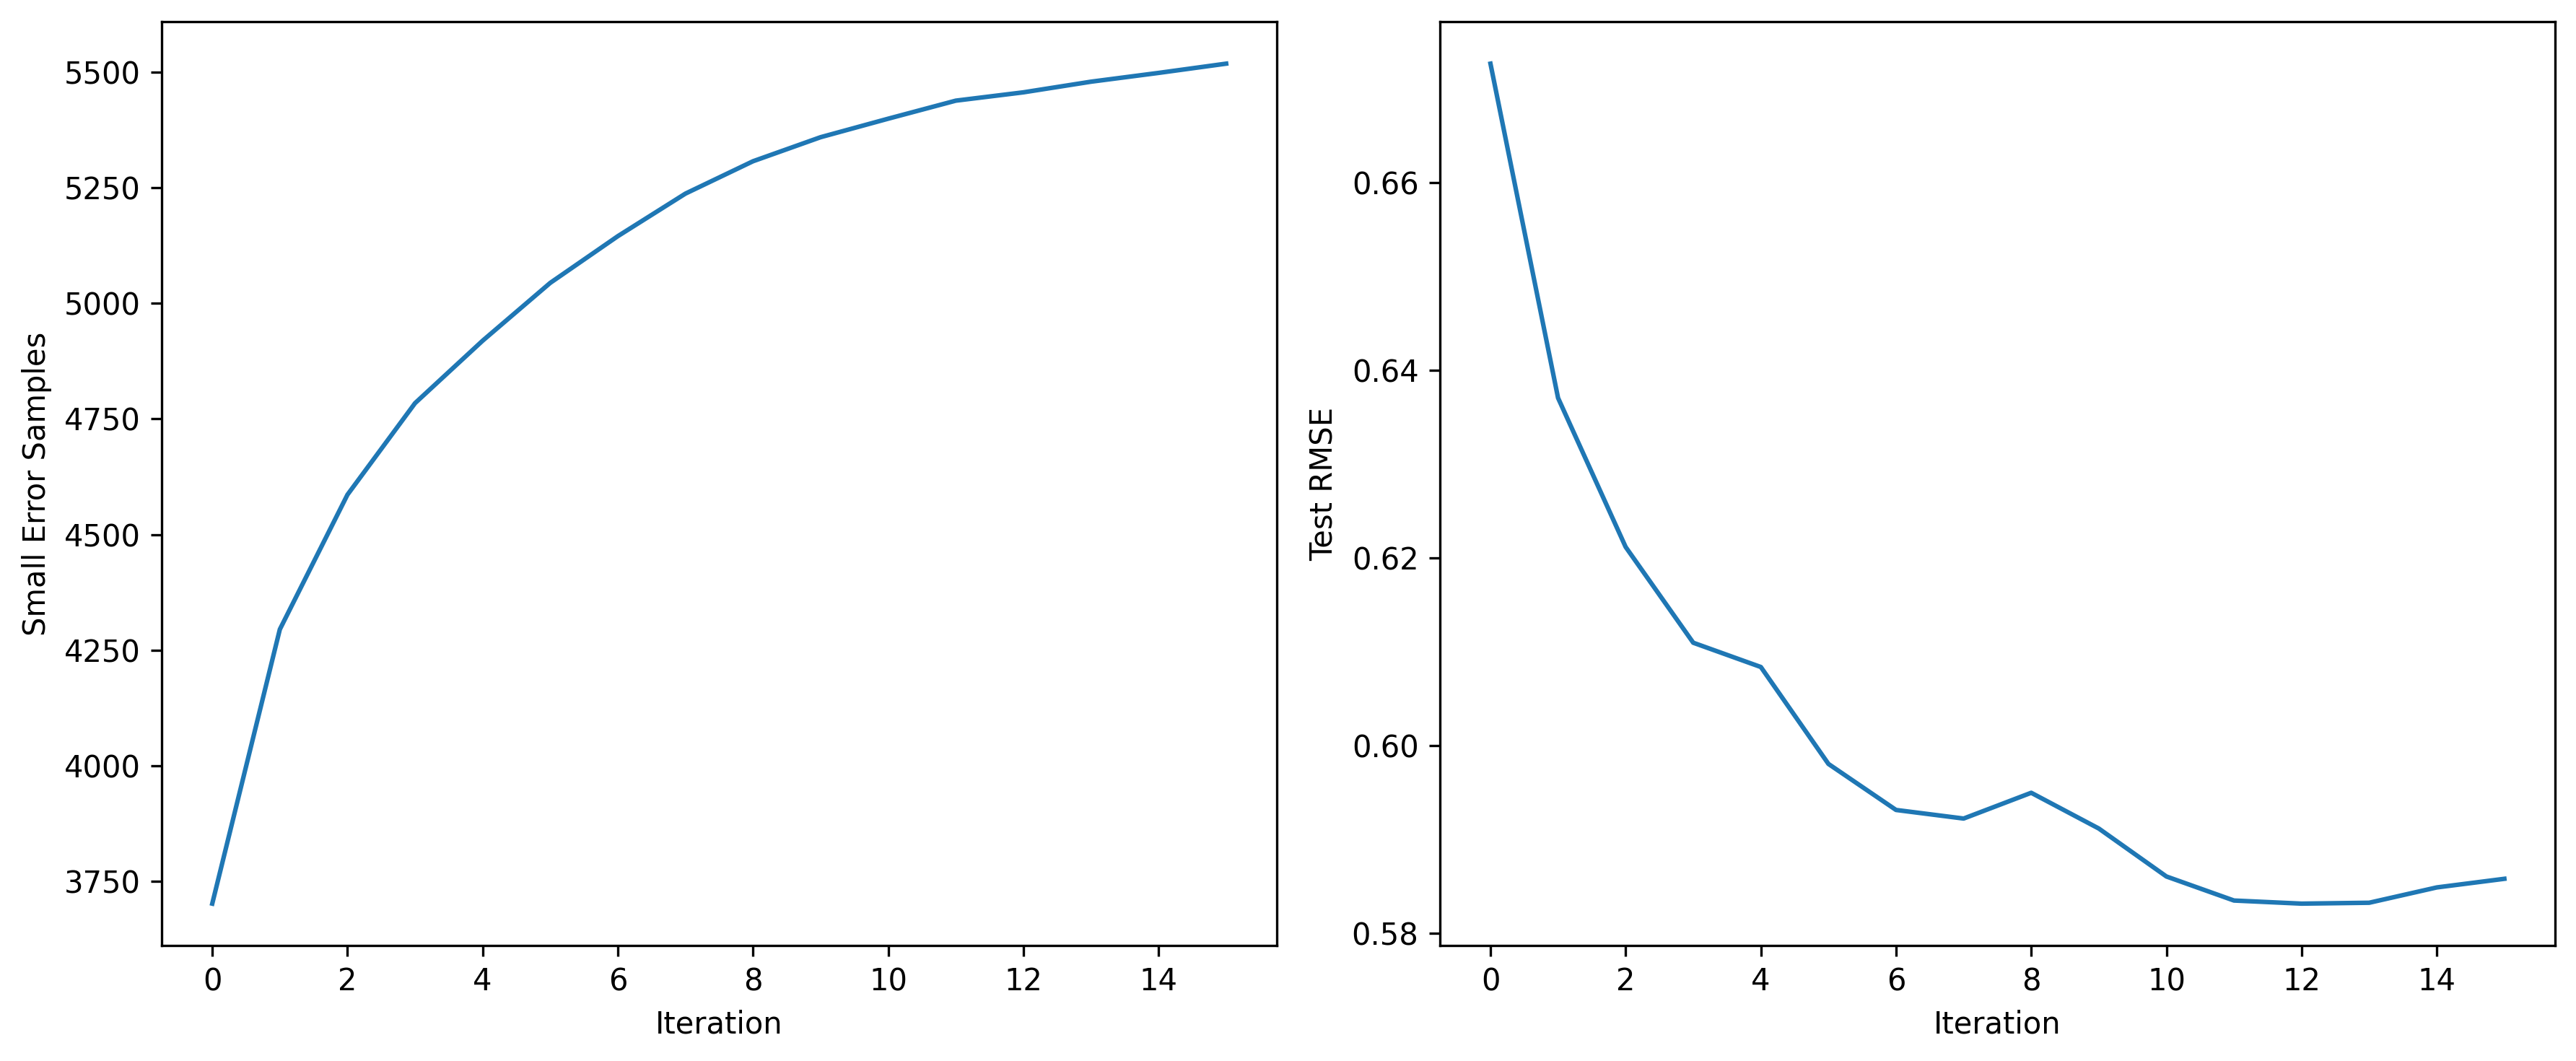

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot([m['iteration'] for m in iteration_metrics], 
         [m['small_error_samples'] for m in iteration_metrics])
plt.xlabel('Iteration')
plt.ylabel('Small Error Samples')
plt.subplot(1, 2, 2)
plt.plot([m['iteration'] for m in iteration_metrics], 
         [m['test_rmse'] for m in iteration_metrics])
plt.xlabel('Iteration')
plt.ylabel('Test RMSE')
plt.tight_layout()
# plt.savefig(os.path.join(file_path, 'iteration_metrics.png'))

####################################################################################################
[DFT - Self Learning XGBoost] Training Self Learning XGBoost on Mix data:
----------------------------------------------------------------------------------------------------
[Train_error] Evaluating Self Learning XGBoost on train set:


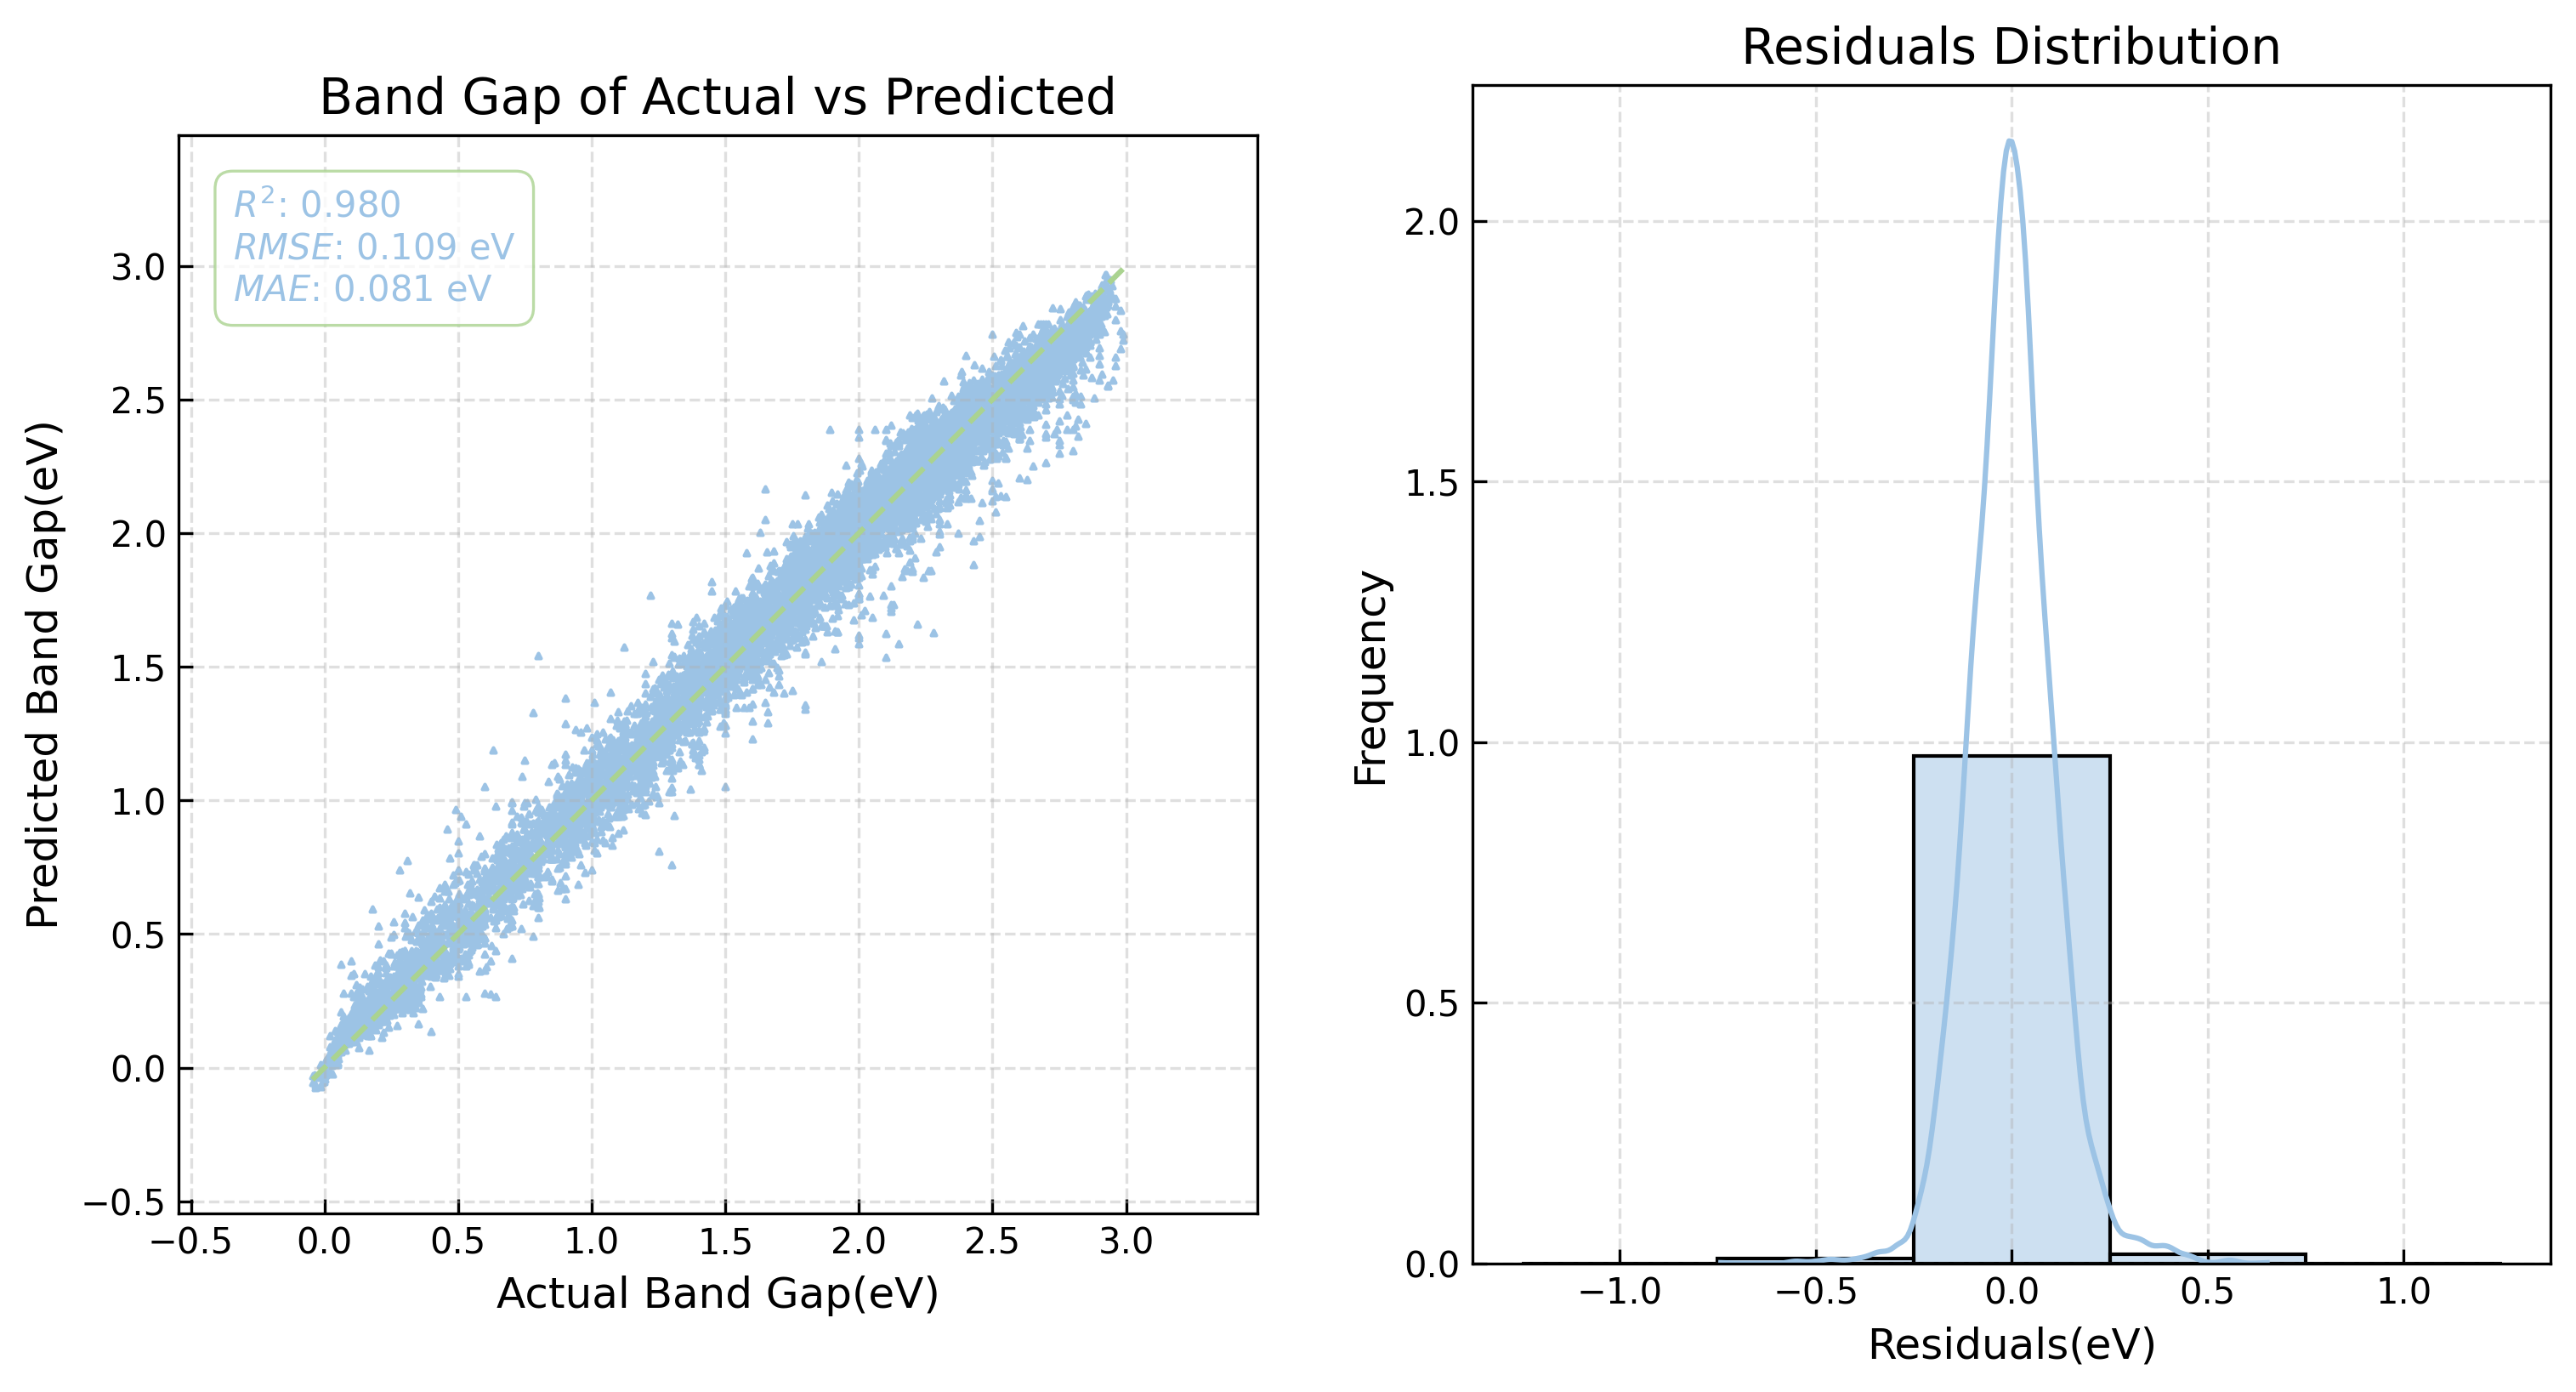


Model Evaluation Results:
Test set size: 8043
Test set: R²: 0.9798 RMSE: 0.1089 MAE: 0.0814 MAPE: 11.2498%
[Test MIX -> DFT] Evaluating Self Learning XGBoost on DFT test set:


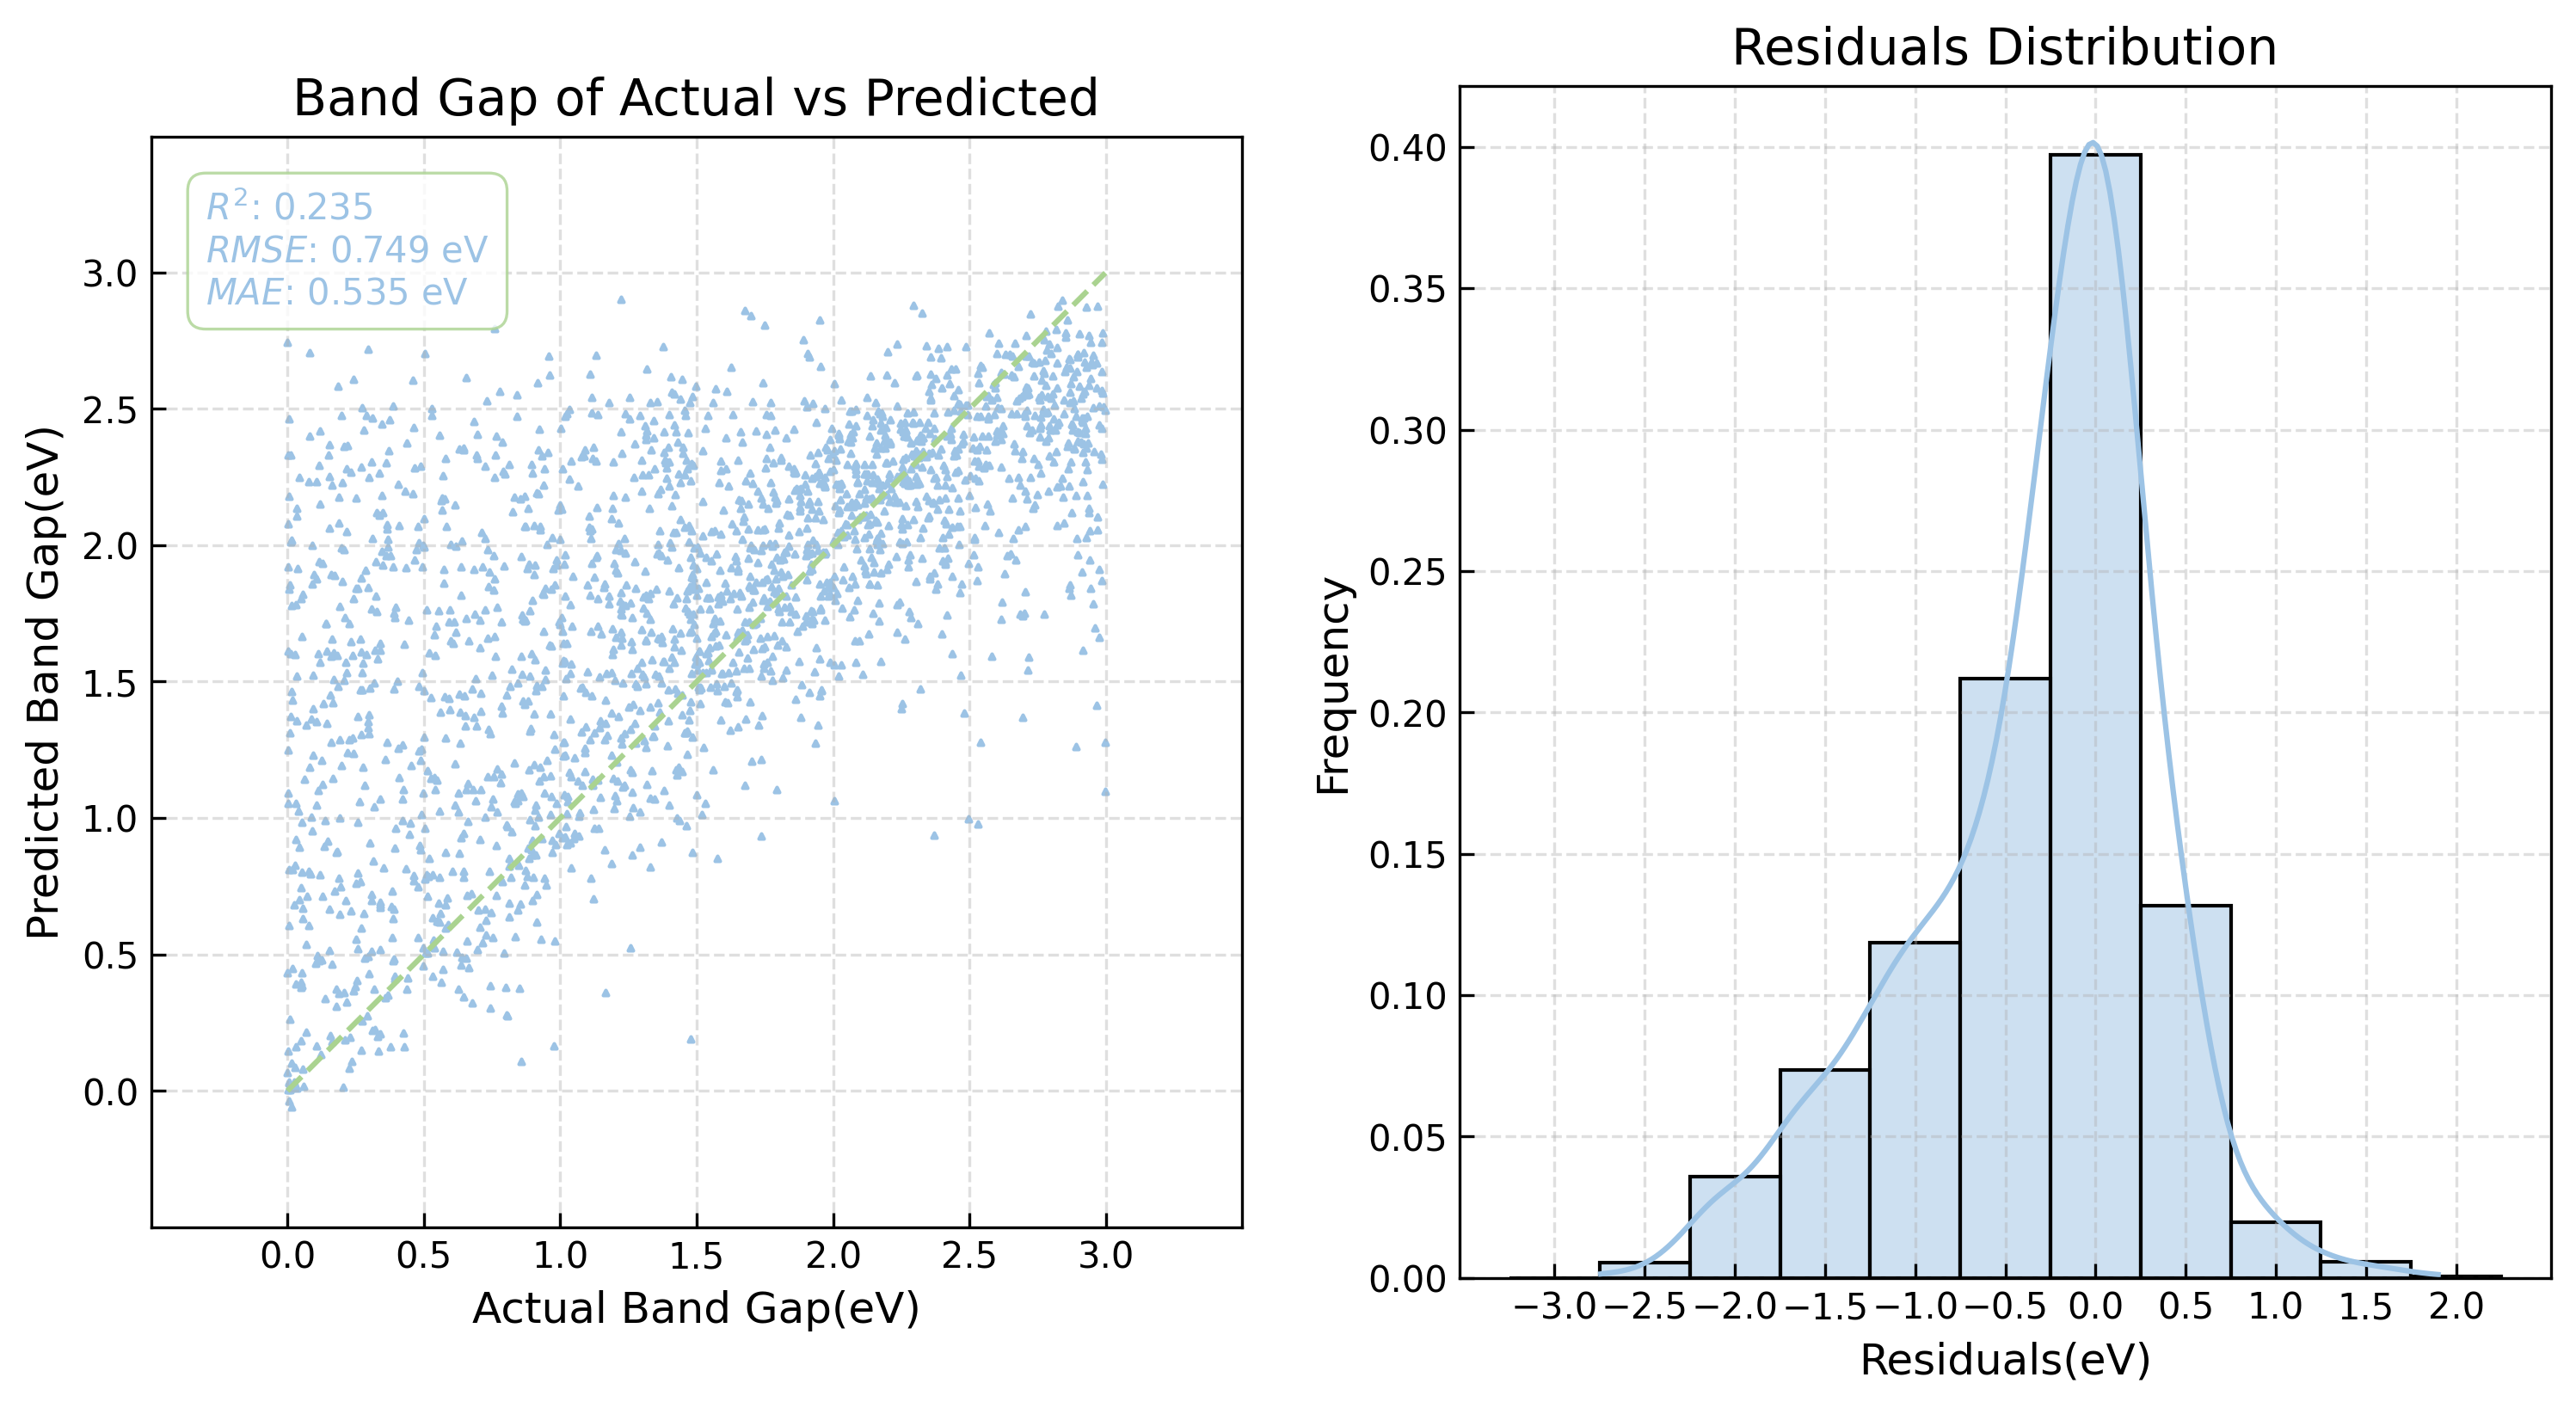


Model Evaluation Results:
Test set size: 2067
Test set: R²: 0.2351 RMSE: 0.7486 MAE: 0.5352 MAPE: 1354.0457%
[Test MIX -> EXP] Evaluating Self Learning XGBoost on EXP test set:


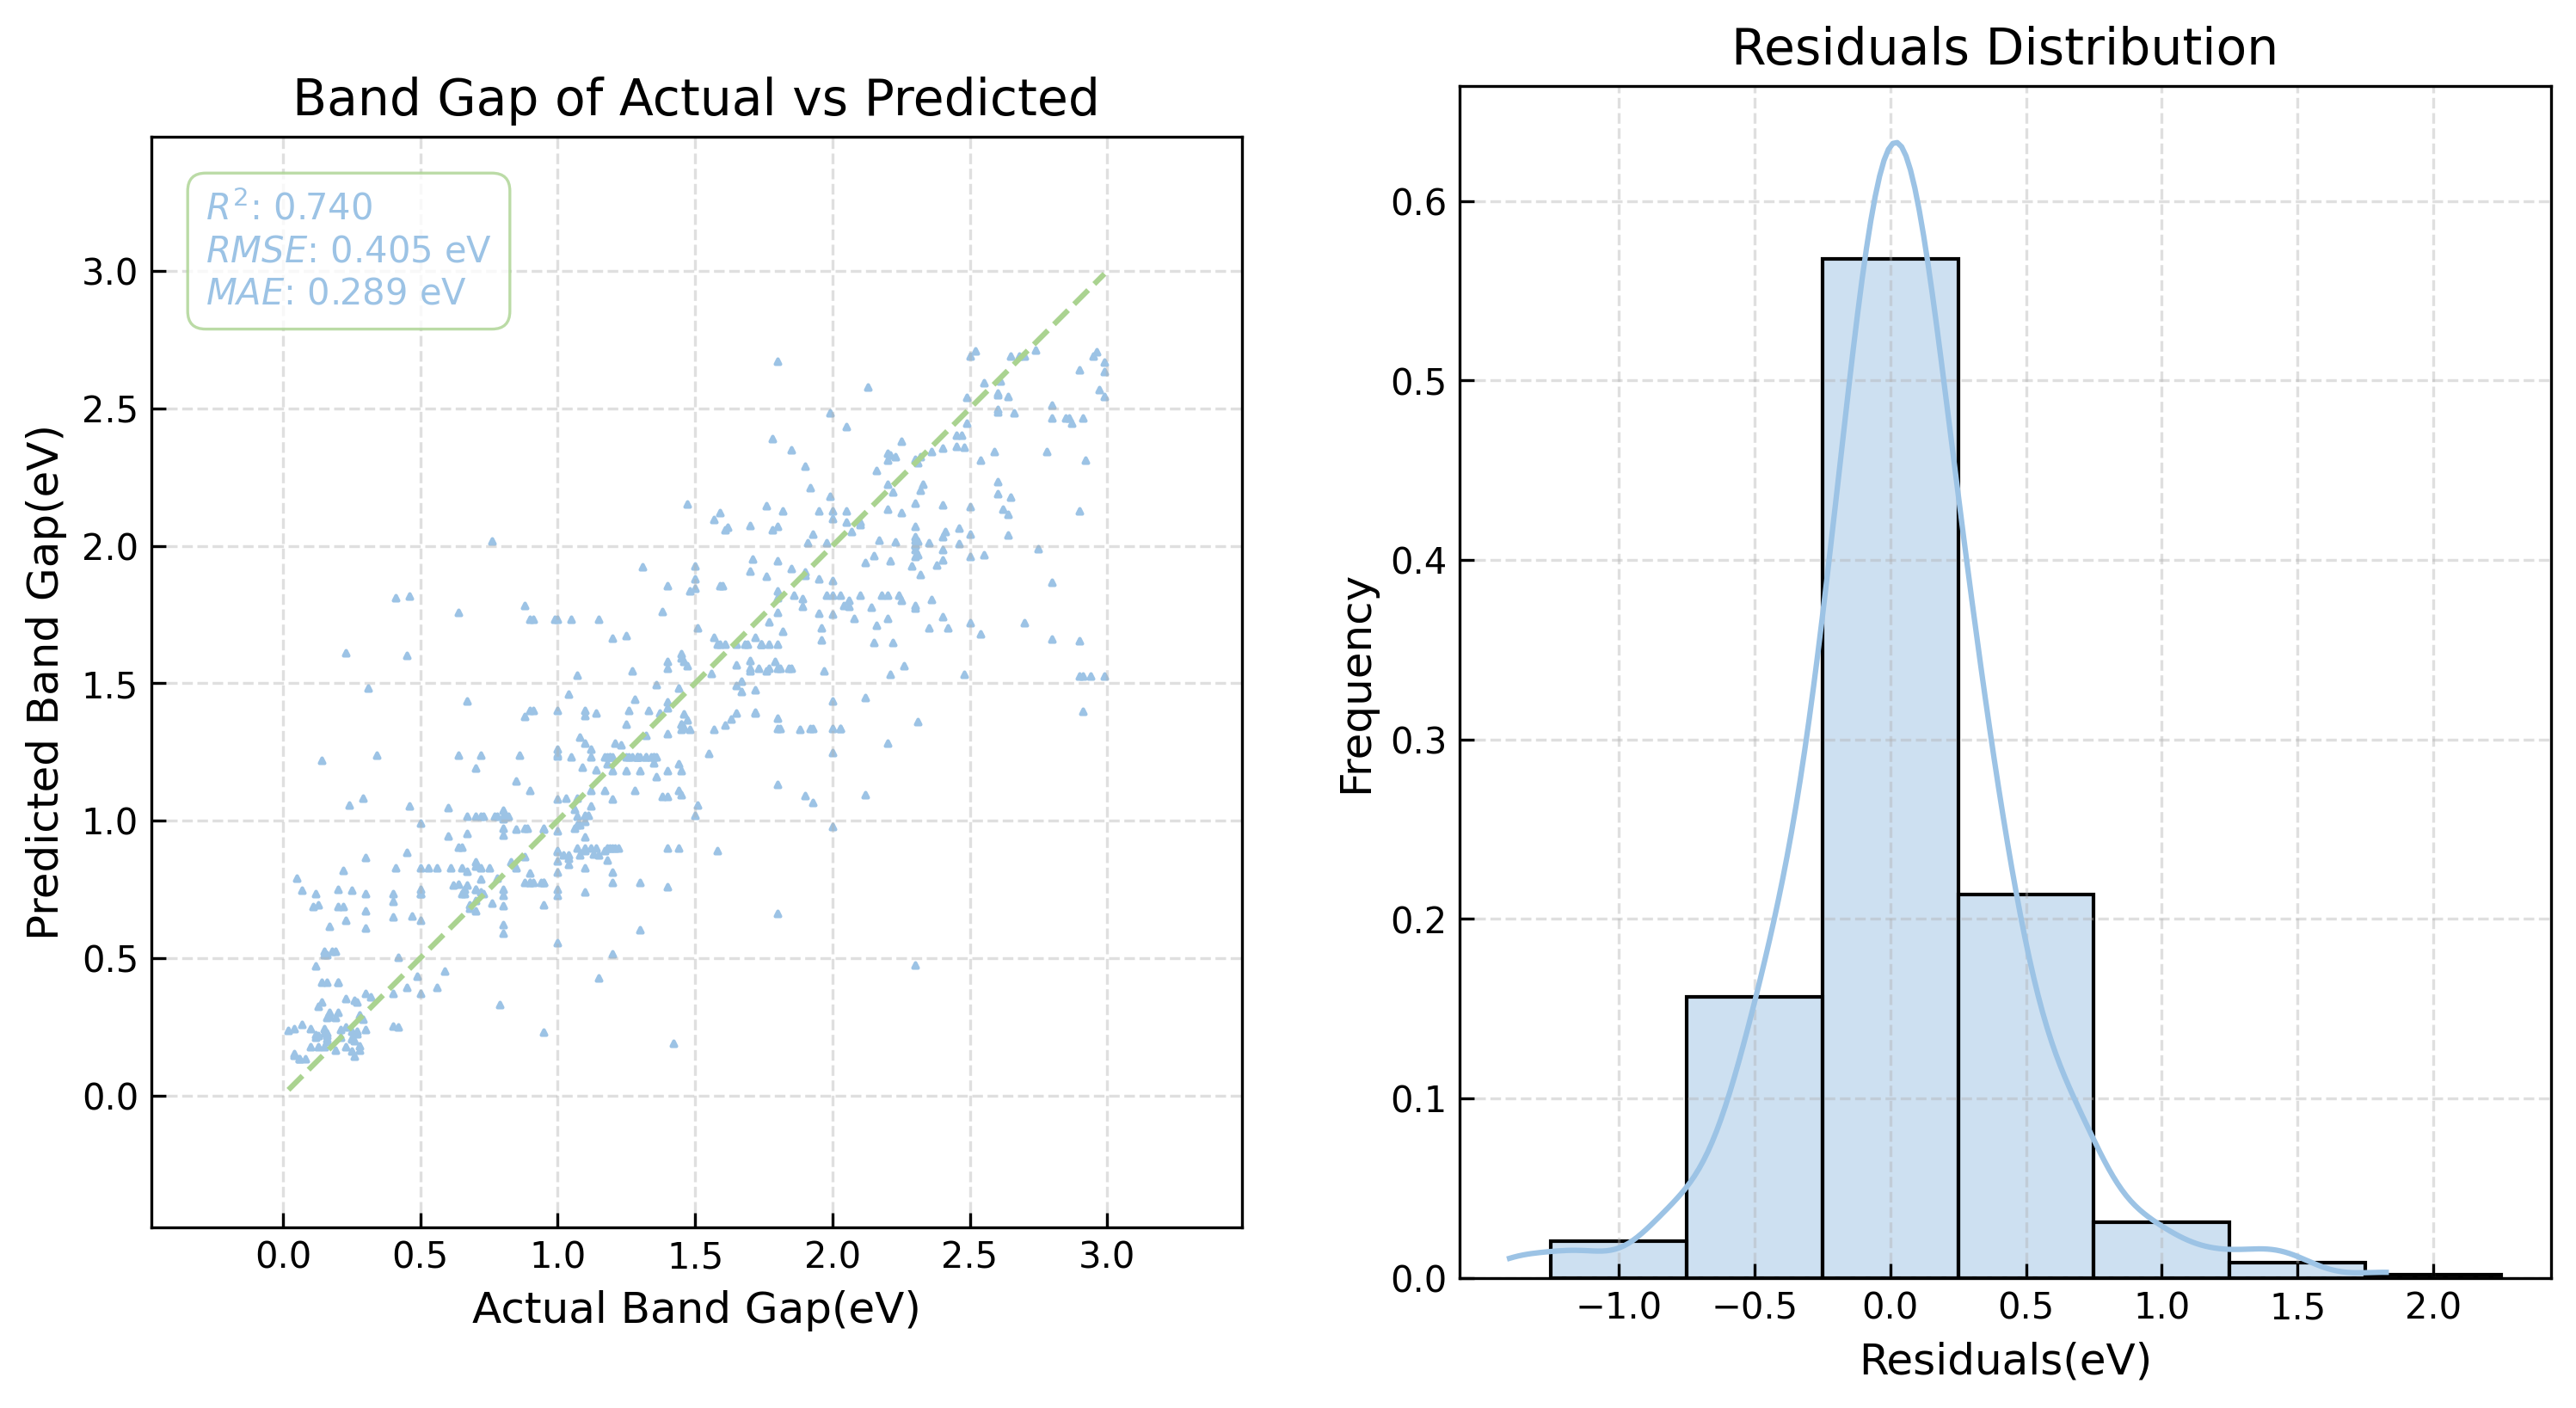


Model Evaluation Results:
Test set size: 585
Test set: R²: 0.7395 RMSE: 0.4045 MAE: 0.2891 MAPE: 45.5579%
[Test MIX -> MIX] Evaluating Self Learning XGBoost on mixed test set:


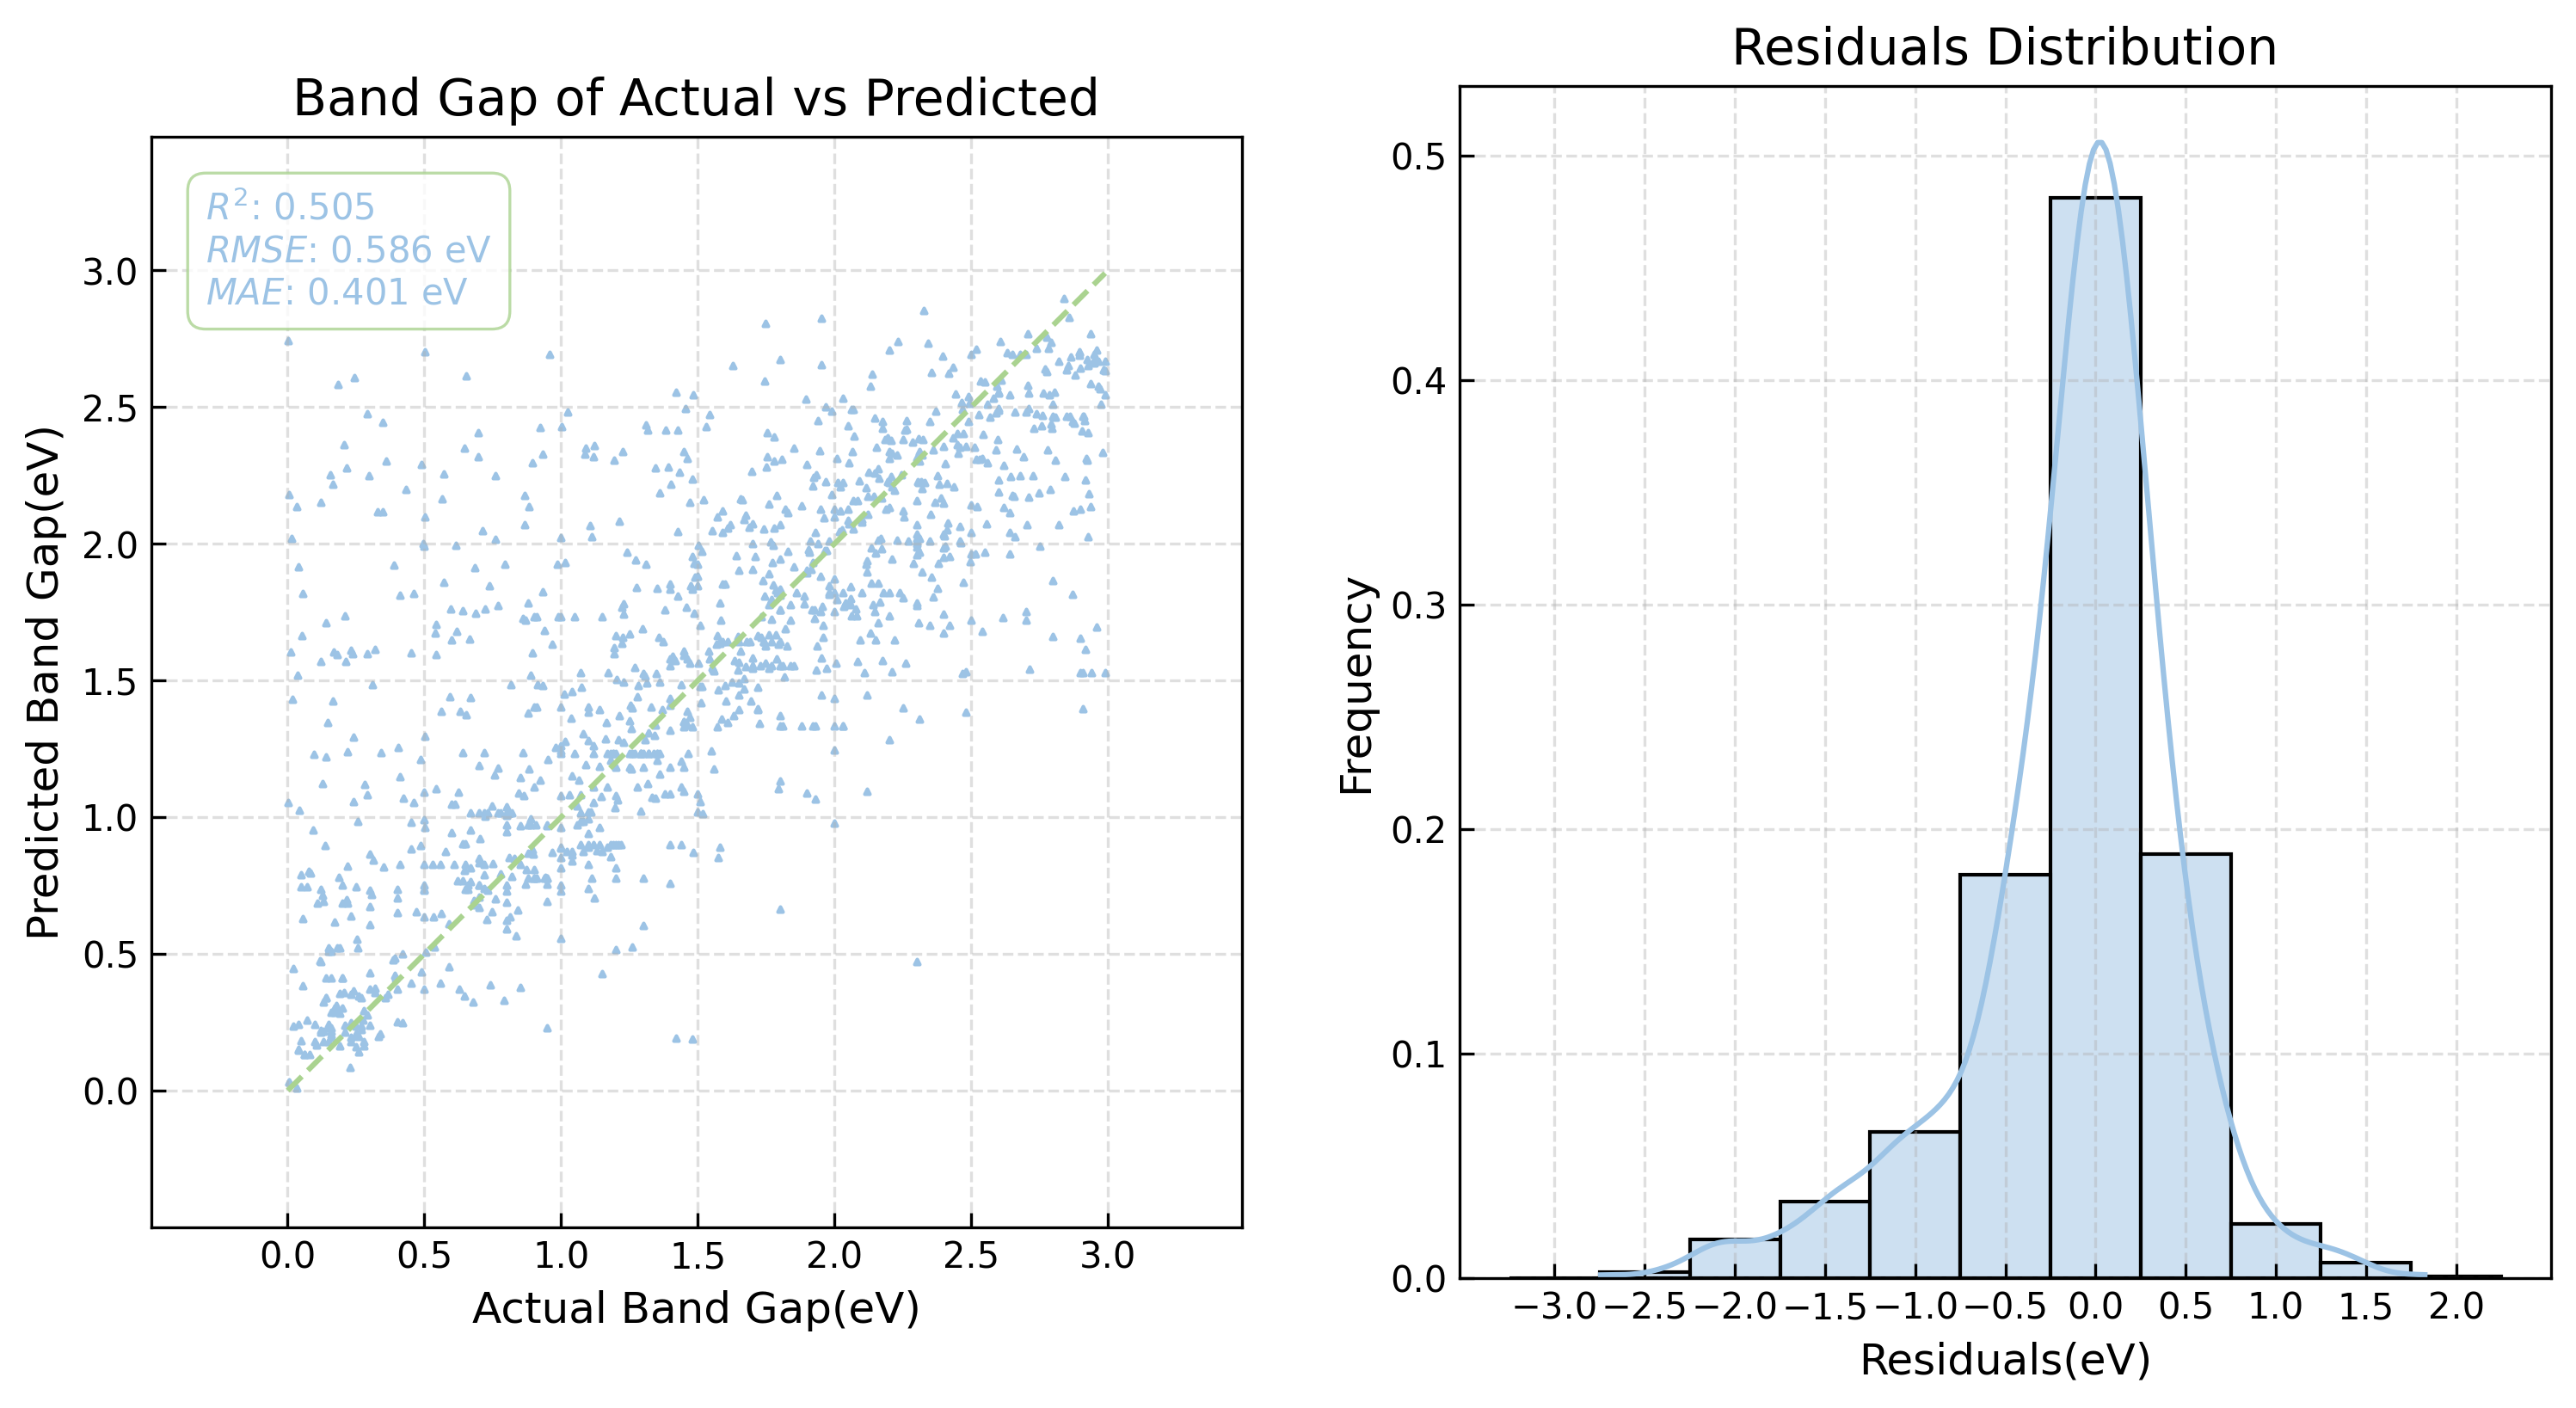


Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.5050 RMSE: 0.5858 MAE: 0.4009 MAPE: 1402.4328%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Self Learning XGBoost,Train,mix,mix,0.979795,0.108891,0.081410
1,Self Learning XGBoost,Test,mix,dft,0.235136,0.748583,0.535187
2,Self Learning XGBoost,Test,mix,exp,0.739510,0.404529,0.289146
3,Self Learning XGBoost,Test,mix,mix,0.504964,0.585825,0.400871


In [10]:
# 
MODEL_NAME = 'Self Learning XGBoost'
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on Mix data:")
print("-" * 100)

model = eventually_model

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(train_X, train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test MIX -> DFT] Evaluating {MODEL_NAME} on DFT test set:")

metrics = model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test MIX -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test MIX -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(mixed_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join('./metrics', 'self_learning_metrics.csv'), index=False)
model_metrics

**Compare to direct mix:**
- the self-learning model has a better performance on the **exp test set**, 
- but the performance on the dft test set is not as good as the direct mix model.

- Sampled dft train data model is not good as the total dft train data model.